## Artificial Neural Networks

### Import libraries 

In [1]:
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Activation, Dropout
# from keras.layers.normalization import BatchNormalization
# from keras import metrics
# from keras.callbacks import ModelCheckpoint

import pandas as pd
import numpy as np
from scipy import ndimage, fft
import matplotlib.pyplot as plt
import math
import time

from imblearn.over_sampling import SMOTE

from pathlib import Path

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from sklearn.metrics import classification_report

# from .preprocess_data import LightFluxProcessor
import tensorflow as tf

2024-11-22 09:05:32.995983: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 09:05:33.274799: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 09:05:33.535876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732262733.727394   26574 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732262733.786592   26574 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 09:05:34.337877: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
class LightFluxProcessor:

    def __init__(self, fourier=True, normalize=True, gaussian=True, standardize=True):
        self.fourier = fourier
        self.normalize = normalize
        self.gaussian = gaussian
        self.standardize = standardize

    # Computing the FFT on X and returning the amplitude of the frequencies in the signal 
    def fourier_transform(self, X):
        return np.abs(fft.fft(X, n=X.size))

    # Applying fourier transform
    def process(self, df_train_x, df_dev_x):
        if self.fourier:
            print("Applying Fourier...")
            shape_train = df_train_x.shape
            shape_dev = df_dev_x.shape
            df_train_x = df_train_x.apply(self.fourier_transform, axis=1)
            df_dev_x = df_dev_x.apply(self.fourier_transform, axis=1)

            # builds new arrays to sore the transformed rows 
            df_train_x_build = np.zeros(shape_train)
            df_dev_x_build = np.zeros(shape_dev)

            for ii, x in enumerate(df_train_x): #?
                df_train_x_build[ii] = x

            for ii, x in enumerate(df_dev_x): #?
                df_dev_x_build[ii] = x

            df_train_x = pd.DataFrame(df_train_x_build)
            df_dev_x = pd.DataFrame(df_dev_x_build)

            # Keep first half of data as it is symmetrical after previous steps (FFT results are symmetric)
            df_train_x = df_train_x.iloc[:, : (df_train_x.shape[1] // 2)].values
            df_dev_x = df_dev_x.iloc[:, : (df_dev_x.shape[1] // 2)].values

        # Normalizing to unit norm
        if self.normalize:
            print("Normalizing...")
            df_train_x = pd.DataFrame(normalize(df_train_x)) 
            df_dev_x = pd.DataFrame(normalize(df_dev_x))

            # df_train_x = df_train_x.div(df_train_x.sum(axis=1), axis=0)
            # df_dev_x = df_dev_x.div(df_dev_x.sum(axis=1), axis=0)

        # Gaussian filter to smooth out data (to remove noise)
        if self.gaussian:
            print("Applying Gaussian Filter...")
            df_train_x = ndimage.gaussian_filter(df_train_x, sigma=10)
            df_dev_x = ndimage.gaussian_filter(df_dev_x, sigma=10)

        # Standardize X data
        if self.standardize:
            print("Standardizing...")
            std_scaler = StandardScaler()
            df_train_x = std_scaler.fit_transform(df_train_x)
            df_dev_x = std_scaler.transform(df_dev_x)

        print("Finished Processing!")
        return df_train_x, df_dev_x

### Build the model 

In [3]:
np.random.seed(1)

def build_network(shape, n_layers, n_neurons):

    model = tf.keras.models.Sequential(
        [
        tf.keras.layers.Input(shape), # input layer defined by 'shape' parameter  
        tf.keras.layers.Flatten(), # covert into 1d array
        ])
    
    for n in range(n_layers):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))  # Dense layer with 1 unit and ReLU
        model.add(tf.keras.layers.Dropout(rate=0.25)) # Dropout layer to prevent overfitting 
    
    model.add(tf.keras.layers.Dense(1, activation="sigmoid")) # output layer with sigmoid

    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False) # False as we applied a sigmoid activation function so we interpret the outputs as probabilities 
    model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
    return model

# output: X (numpy array of features) and Y (numpy array of lables - 1 or 2)
def np_X_Y_from_df(df):
    df = shuffle(df)
    df_X = df.drop(["LABEL"], axis=1)
    X = np.array(df_X)
    Y_raw = np.array(df["LABEL"]).reshape((len(df["LABEL"]), 1))
    Y = Y_raw == 2
    return X, Y


### Load and process the dataset

In [4]:
def load_data(train_dataset_path, dev_dataset_path):
    print("Loading datasets...")
    df_train = pd.read_csv(train_dataset_path, encoding="ISO-8859-1")
    df_dev = pd.read_csv(dev_dataset_path, encoding="ISO-8859-1")

    # Generate X and Y dataframe sets
    df_train_x = df_train.drop("LABEL", axis=1)
    df_dev_x = df_dev.drop("LABEL", axis=1)
    df_train_y = df_train.LABEL
    df_dev_y = df_dev.LABEL

    # Process dataset with LPF
    LFP = LightFluxProcessor(
        fourier=True, normalize=True, gaussian=True, standardize=True
    )
    df_train_x, df_dev_x = LFP.process(df_train_x, df_dev_x)

    # Rejoin X and Y to form dataframe 
    df_train_processed = pd.DataFrame(df_train_x).join(pd.DataFrame(df_train_y))
    df_dev_processed = pd.DataFrame(df_dev_x).join(pd.DataFrame(df_dev_y))

    # Load X and Y numpy arrays
    X_train, Y_train = np_X_Y_from_df(df_train_processed)
    X_dev, Y_dev = np_X_Y_from_df(df_dev_processed)

    # Print data set stats
    (num_examples, n_x) = (X_train.shape)  # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[1]  # n_y : output size
    print("X_train.shape: ", X_train.shape)
    print("Y_train.shape: ", Y_train.shape)
    print("X_dev.shape: ", X_dev.shape)
    print("Y_dev.shape: ", Y_dev.shape)
    
    return X_train, Y_train, X_dev, Y_dev

### NN on no injection data

In [7]:
path_to_data = '../data/kepler'
train_dataset_path = f"{path_to_data}/data_no_injection/exoTrain.csv"
dev_dataset_path = f"{path_to_data}/data_no_injection/exoTest.csv"

LOAD_MODEL = True  # continue training previous weights or start fresh
RENDER_PLOT = True  # render loss and accuracy plots

Below we run the model with deafult parameters (one hidden layer and one neuron per layer)

Loading datasets...
Applying Fourier...
Normalizing...
Applying Gaussian Filter...
Standardizing...
Finished Processing!
X_train.shape:  (5087, 1598)
Y_train.shape:  (5087, 1)
X_dev.shape:  (570, 1598)
Y_dev.shape:  (570, 1)
Training...


2024-11-22 09:10:28.052774: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64559200 exceeds 10% of free system memory.


train set error 0.0003931590328287715
dev set error 0.010526315789473717
------------
precision_train 0.9487179487179487
precision_dev 0.45454545454545453
------------
recall_train 1.0
recall_dev 1.0
------------
confusion_matrix_train
[[5048    2]
 [   0   37]]
confusion_matrix_dev
[[559   6]
 [  0   5]]
------------
Train Set Positive Predictions 39
Dev Set Positive Predictions 11
------------
All 0's error train set 0.007273442107332416
All 0's error dev set 0.008771929824561403
------------
------------
dict_keys(['accuracy', 'loss'])


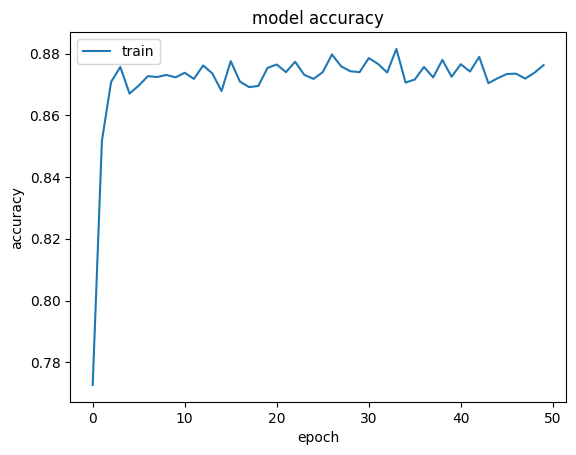

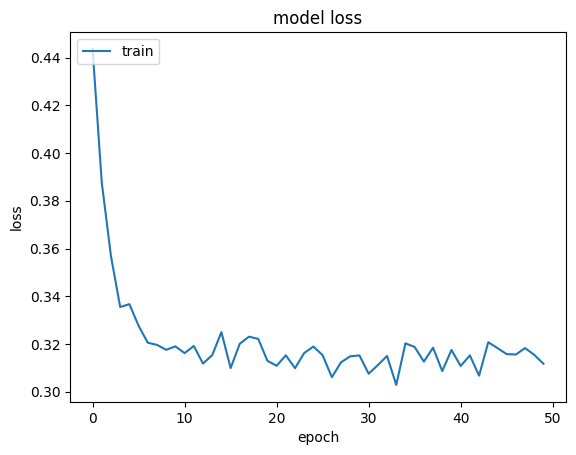

In [8]:
X_train, Y_train, X_dev, Y_dev = load_data(train_dataset_path, dev_dataset_path)
model = build_network(X_train.shape[1:], n_layers=1, n_neurons=1)

############## do we want to balance using SMOTE ??
sm = SMOTE()
X_train_sm, Y_train_sm = sm.fit_resample(X_train, Y_train)

# Training the NN 
print("Training...")

history = model.fit(X_train_sm, Y_train_sm, epochs=50, batch_size=32, verbose=0)

train_outputs = model.predict(X_train, batch_size=32, verbose=0) 
dev_outputs = model.predict(X_dev, batch_size=32, verbose=0) 
train_outputs = np.rint(train_outputs)
dev_outputs = np.rint(dev_outputs)

# Metrics
accuracy_train = accuracy_score(Y_train, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)

print("train set error", 1.0 - accuracy_train)
print("dev set error", 1.0 - accuracy_dev)
print("------------")
print("precision_train", precision_train)
print("precision_dev", precision_dev)
print("------------")
print("recall_train", recall_train)
print("recall_dev", recall_dev)
print("------------")
print("confusion_matrix_train")
print(confusion_matrix_train)
print("confusion_matrix_dev")
print(confusion_matrix_dev)
print("------------")
print("Train Set Positive Predictions", np.count_nonzero(train_outputs))
print("Dev Set Positive Predictions", np.count_nonzero(dev_outputs))
#  Predicting 0's will give you error:
print("------------")
print("All 0's error train set", 37 / 5087)
print("All 0's error dev set", 5 / 570)

print("------------")
print("------------")

if RENDER_PLOT:
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history["accuracy"])
    # plt.plot(history.history['val_acc'])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

    # summarize history for loss
    plt.plot(history.history["loss"])
    # plt.plot(history.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

We go on varying the number of layers and number of neurons per layer

In [9]:
import itertools

n_layers = [1,2,3]
n_neurons = [16,32,64]
combinations = list(itertools.product(n_layers, n_neurons))

for combo in combinations:
    model = build_network(X_train.shape[1:], n_layers=combo[0], n_neurons=combo[1])

    sm = SMOTE()
    X_train_sm, Y_train_sm = sm.fit_resample(X_train, Y_train)

    # Training the NN 
    print(f"Training with {combo[0]} hidden layers and {combo[1]} neurons per layer...")

    history = model.fit(X_train_sm, Y_train_sm, epochs=50, batch_size=32, verbose=0)

    train_outputs = model.predict(X_train, batch_size=32, verbose=0) 
    dev_outputs = model.predict(X_dev, batch_size=32, verbose=0) 
    train_outputs = np.rint(train_outputs)
    dev_outputs = np.rint(dev_outputs)

    confusion_matrix_train = confusion_matrix(Y_train, train_outputs)
    confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)

    print("confusion_matrix_train")
    print(confusion_matrix_train)
    print("confusion_matrix_dev")
    print(confusion_matrix_dev)

    print("------------")
    print("------------")

Training with 1 hidden layers and 16 neurons per layer...


2024-11-22 09:16:33.939398: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64559200 exceeds 10% of free system memory.


confusion_matrix_train
[[5047    3]
 [   0   37]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
------------
Training with 1 hidden layers and 32 neurons per layer...


2024-11-22 09:17:30.564951: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64559200 exceeds 10% of free system memory.


confusion_matrix_train
[[5047    3]
 [   0   37]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
------------
Training with 1 hidden layers and 64 neurons per layer...


2024-11-22 09:18:37.221535: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64559200 exceeds 10% of free system memory.


confusion_matrix_train
[[5047    3]
 [   0   37]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
------------
Training with 2 hidden layers and 16 neurons per layer...
confusion_matrix_train
[[5046    4]
 [   0   37]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
------------
Training with 2 hidden layers and 32 neurons per layer...
confusion_matrix_train
[[5046    4]
 [   0   37]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
------------
Training with 2 hidden layers and 64 neurons per layer...
confusion_matrix_train
[[5049    1]
 [   0   37]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
------------
Training with 3 hidden layers and 16 neurons per layer...
confusion_matrix_train
[[5046    4]
 [   0   37]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
------------
Training with 3 hidden layers and 32 neurons per layer...
confusion_matrix_train
[[5046    4]
 [   0   37]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
---

### NN on injection data

Loading datasets...
Applying Fourier...
Normalizing...
Applying Gaussian Filter...
Standardizing...
Finished Processing!
X_train.shape:  (5087, 1598)
Y_train.shape:  (5087, 1)
X_dev.shape:  (570, 1598)
Y_dev.shape:  (570, 1)
Training...
train set error 0.4949872223314331
dev set error 0.4894736842105263
------------
precision_train 0.6055384615384616
precision_dev 0.5748987854251012
------------
recall_train 0.34393568682278924
recall_dev 0.44936708860759494
------------
confusion_matrix_train
[[1585  641]
 [1877  984]]
confusion_matrix_dev
[[149 105]
 [174 142]]
------------
Train Set Positive Predictions 1625
Dev Set Positive Predictions 247
------------
All 0's error train set 0.007273442107332416
All 0's error dev set 0.008771929824561403
------------
------------
dict_keys(['accuracy', 'loss'])


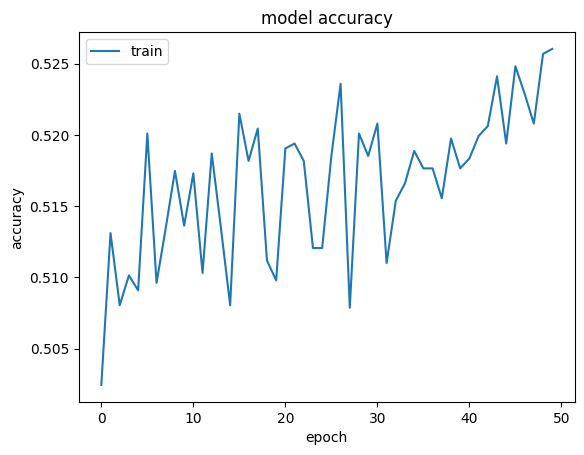

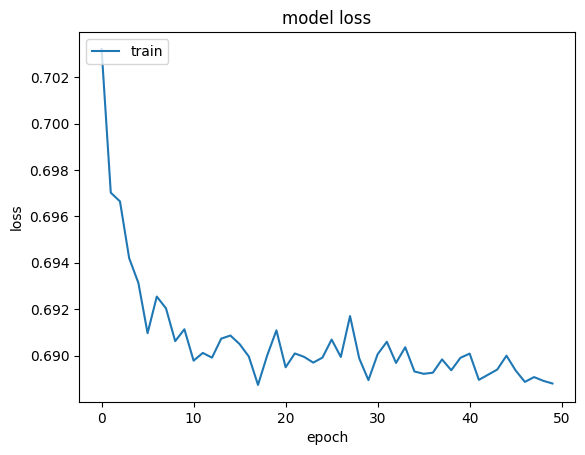

In [10]:
train_dataset_path = f"{path_to_data}/data_injected/exoTrain.csv"
dev_dataset_path = f"{path_to_data}/data_injected/exoTest.csv"

X_train, Y_train, X_dev, Y_dev = load_data(train_dataset_path, dev_dataset_path)
model = build_network(X_train.shape[1:], n_layers=1, n_neurons=1)

############## do we want to balance using SMOTE ??
sm = SMOTE()
X_train_sm, Y_train_sm = sm.fit_resample(X_train, Y_train)

# Training the NN 
print("Training...")

history = model.fit(X_train_sm, Y_train_sm, epochs=50, batch_size=32, verbose=0)

train_outputs = model.predict(X_train, batch_size=32, verbose=0) 
dev_outputs = model.predict(X_dev, batch_size=3, verbose=0) 
train_outputs = np.rint(train_outputs)
dev_outputs = np.rint(dev_outputs)

# Metrics
accuracy_train = accuracy_score(Y_train, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)

print("train set error", 1.0 - accuracy_train)
print("dev set error", 1.0 - accuracy_dev)
print("------------")
print("precision_train", precision_train)
print("precision_dev", precision_dev)
print("------------")
print("recall_train", recall_train)
print("recall_dev", recall_dev)
print("------------")
print("confusion_matrix_train")
print(confusion_matrix_train)
print("confusion_matrix_dev")
print(confusion_matrix_dev)
print("------------")
print("Train Set Positive Predictions", np.count_nonzero(train_outputs))
print("Dev Set Positive Predictions", np.count_nonzero(dev_outputs))
#  Predicting 0's will give you error:
print("------------")
print("All 0's error train set", 37 / 5087)
print("All 0's error dev set", 5 / 570)

print("------------")
print("------------")

if RENDER_PLOT:
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history["accuracy"])
    # plt.plot(history.history['val_acc'])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

    # summarize history for loss
    plt.plot(history.history["loss"])
    # plt.plot(history.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

In [11]:
for combo in combinations:
    model = build_network(X_train.shape[1:], n_layers=combo[0], n_neurons=combo[1])

    sm = SMOTE()
    X_train_sm, Y_train_sm = sm.fit_resample(X_train, Y_train)

    # Training the NN 
    print(f"Training with {combo[0]} hidden layers and {combo[1]} neurons per layer...")

    history = model.fit(X_train_sm, Y_train_sm, epochs=50, batch_size=32, verbose=0)

    train_outputs = model.predict(X_train, batch_size=32, verbose=0) 
    dev_outputs = model.predict(X_dev, batch_size=32, verbose=0) 
    train_outputs = np.rint(train_outputs)
    dev_outputs = np.rint(dev_outputs)

    
    accuracy_train = accuracy_score(Y_train, train_outputs)
    accuracy_dev = accuracy_score(Y_dev, dev_outputs)
    confusion_matrix_train = confusion_matrix(Y_train, train_outputs)
    confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)

    print("train set error", 1.0 - accuracy_train)
    print("dev set error", 1.0 - accuracy_dev)
    print("------------")
    print("confusion_matrix_train")
    print(confusion_matrix_train)
    print("confusion_matrix_dev")
    print(confusion_matrix_dev)

    print("------------")
    print("------------")

Training with 1 hidden layers and 16 neurons per layer...
train set error 0.473756634558679
dev set error 0.5
------------
confusion_matrix_train
[[1474  752]
 [1658 1203]]
confusion_matrix_dev
[[172  82]
 [203 113]]
------------
------------
Training with 1 hidden layers and 32 neurons per layer...
train set error 0.5083546294476116
dev set error 0.5333333333333333
------------
confusion_matrix_train
[[1890  336]
 [2250  611]]
confusion_matrix_dev
[[228  26]
 [278  38]]
------------
------------
Training with 1 hidden layers and 64 neurons per layer...
train set error 0.45468842146648314
dev set error 0.4473684210526315
------------
confusion_matrix_train
[[1034 1192]
 [1121 1740]]
confusion_matrix_dev
[[ 53 201]
 [ 54 262]]
------------
------------
Training with 2 hidden layers and 16 neurons per layer...
train set error 0.5048161981521526
dev set error 0.5473684210526315
------------
confusion_matrix_train
[[1939  287]
 [2281  580]]
confusion_matrix_dev
[[236  18]
 [294  22]]
-----